<a href="https://colab.research.google.com/github/weasel-codes/covid19-icu-prediction/blob/main/covid19_icu_requirement_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid19 Prediciton and ICU Requirement**

Work done by : Nitin Sharma

* Task 1 : Predict confirmed COVID-19 cases among suspected cases.
Based on the results of laboratory tests commonly collected for a suspected COVID-19 case during a visit to the emergency room, would it be possible to predict the test result for SARS-Cov-2 (positive/negative)?

* Task 2 : Predict admission to general ward, semi-intensive unit or intensive care unit among confirmed COVID-19 cases.
Based on the results of laboratory tests commonly collected among confirmed COVID-19 cases during a visit to the emergency room, would it be possible to predict which patients will need to be admitted to a general ward, semi-intensive unit or intensive care unit?

In [25]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

## Dataset Import

In [26]:
db_url = "/content/drive/MyDrive/ML/covid-minor/covid19-dataset.csv"
data = pd.read_csv(db_url)

In [27]:
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dataset Pre-processing

In [28]:
data['Urine - pH'].replace('Não Realizado', np.nan, inplace=True)
data['Urine - pH'] = data['Urine - pH'].astype('float64')
data.replace('not_done', np.nan, inplace=True)
data['Urine - Leukocytes'].replace('<1000', '999', inplace=True)
data['Urine - Leukocytes'] = data['Urine - Leukocytes'].astype('float64')

### Label Encoding

In [29]:
df_temp = data[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']].astype("str").apply(LabelEncoder().fit_transform)
data[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']] = df_temp.where(~data[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']].isna(), data[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']])

data['Urine - Aspect'] = data['Urine - Aspect'].astype("float64")
data['Urine - Urobilinogen'] = data['Urine - Urobilinogen'].astype("float64")
data['Urine - Crystals'] = data['Urine - Crystals'].astype("float64")
data['Urine - Color'] = data['Urine - Color'].astype("float64")


### Drop not needed column

In [30]:
data.drop(columns=[ 'Patient addmited to regular ward (1=yes, 0=no)',
                    'Patient ID',
                    'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                    'Patient addmited to intensive care unit (1=yes, 0=no)'], inplace=True)

In [31]:
data.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Label Encode some columns

In [32]:
data.replace('not_detected', 0, inplace=True)
data.replace('detected', 1, inplace=True)
data.replace('negative', 0, inplace=True)
data.replace('positive', 1, inplace=True)
data.replace('absent', 0, inplace=True)
data.replace('present', 1, inplace=True)

In [33]:
data.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.619086,1.198059,-0.147895,2.089928,-0.305787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking for missing data

,Total,Percent
Mycoplasma pneumoniae,5644,1.000000
Urine - Nitrite,5644,1.000000
Urine - Sugar,5644,1.000000
Partial thromboplastin time (PTT),5644,1.000000
"Prothrombin time (PT), Activity",5644,1.000000
D-Dimer,5644,1.000000
Fio2 (venous blood gas analysis),5643,0.999823
Vitamin B12,5641,0.999468
Lipase dosage,5636,0.998583
Albumin,5631,0.997697


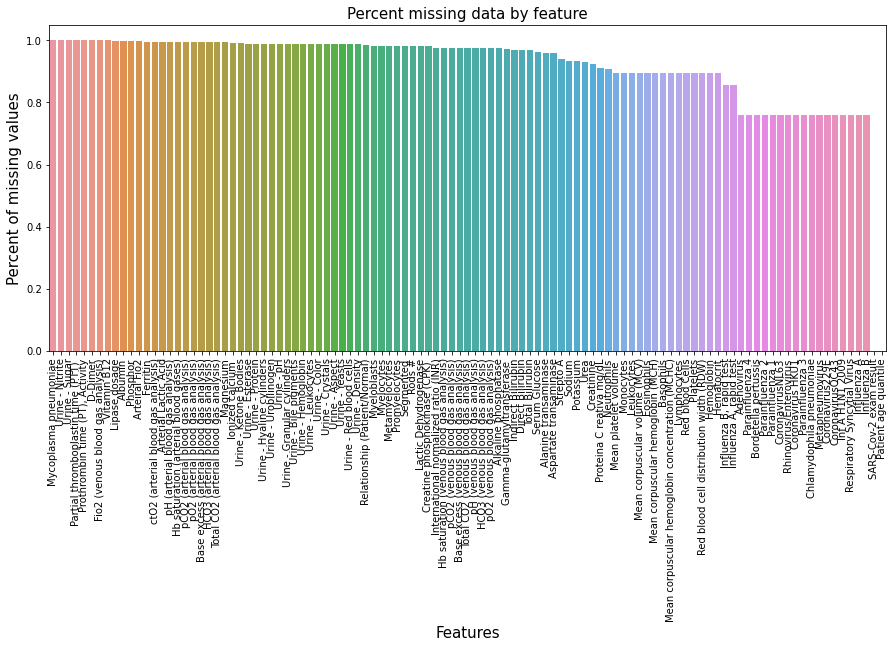

In [34]:
def plot_missing_data(missing_data, title):
    f, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data['Percent'])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title(title, fontsize=15)

def get_missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data = get_missing_data(data)
plot_missing_data(missing_data, 'Percent missing data by feature')
missing_data.head(50)

PLOT % Missing data that were +ve covid cases

,Total,Percent
Fio2 (venous blood gas analysis),558,1.000000
D-Dimer,558,1.000000
Urine - Nitrite,558,1.000000
Partial thromboplastin time (PTT),558,1.000000
"Prothrombin time (PT), Activity",558,1.000000
Vitamin B12,558,1.000000
Mycoplasma pneumoniae,558,1.000000
Urine - Sugar,558,1.000000
Albumin,558,1.000000
Phosphor,557,0.998208


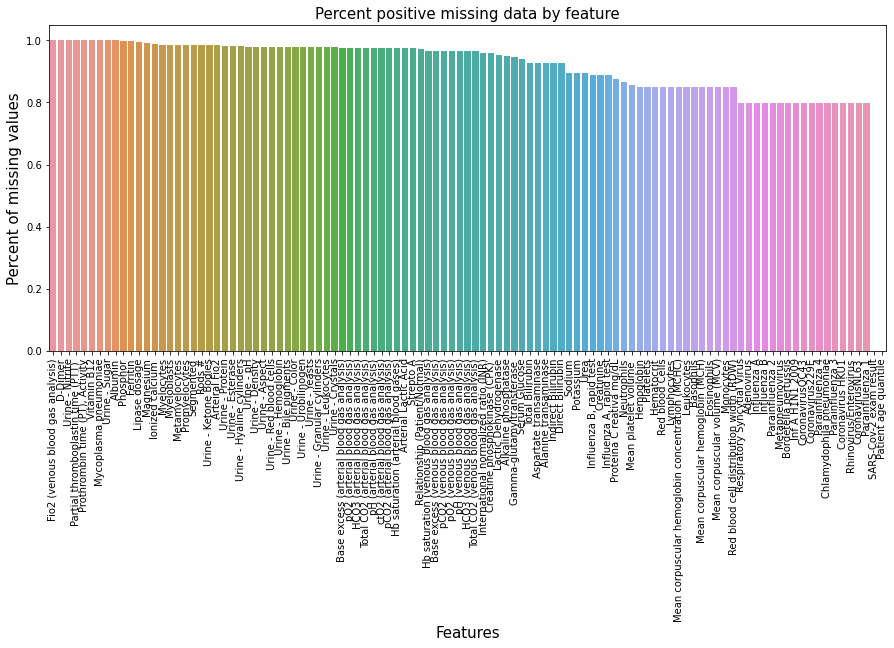

In [35]:
dataset_positive = data[data['SARS-Cov-2 exam result'] == 1]
missing_data_positive = get_missing_data(dataset_positive)

plot_missing_data(missing_data_positive, 'Percent positive missing data by feature')
missing_data_positive.head(10)

PLOT % Missing data that were -ve covid cases

,Total,Percent
Urine - Sugar,5086,1.000000
Partial thromboplastin time (PTT),5086,1.000000
Urine - Nitrite,5086,1.000000
"Prothrombin time (PT), Activity",5086,1.000000
Mycoplasma pneumoniae,5086,1.000000
D-Dimer,5086,1.000000
Fio2 (venous blood gas analysis),5085,0.999803
Vitamin B12,5083,0.999410
Lipase dosage,5081,0.999017
Arteiral Fio2,5075,0.997837


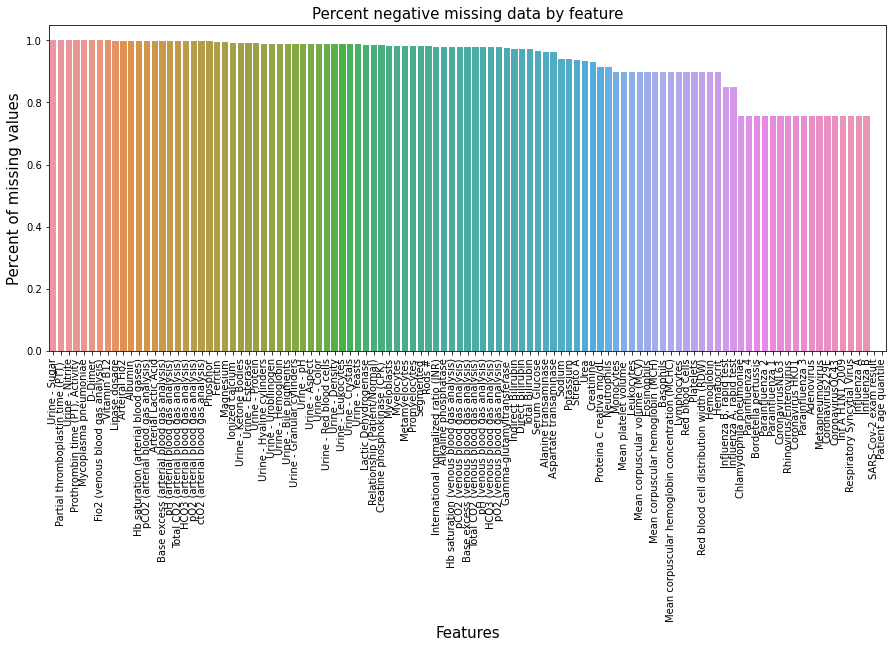

In [36]:
dataset_negative = data[data['SARS-Cov-2 exam result'] == 0]
missing_data_negative = get_missing_data(dataset_negative)

plot_missing_data(missing_data_negative, 'Percent negative missing data by feature')
missing_data_negative.head(10)

### Correlation Data

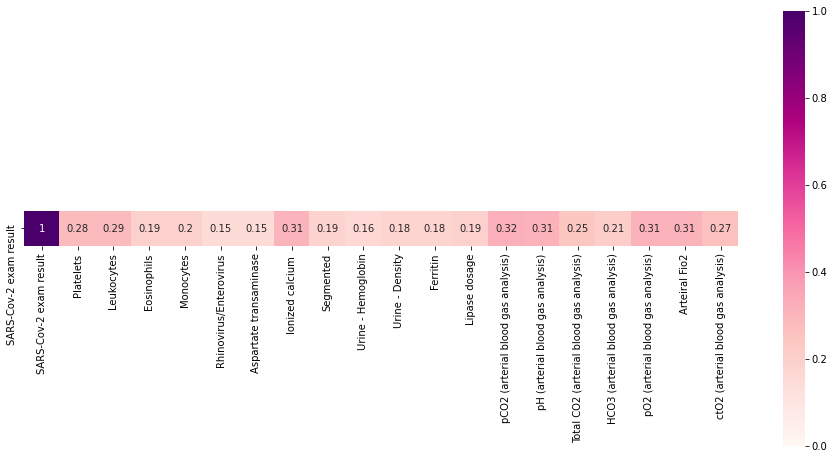

In [37]:
corrmat = abs(data.corr())

# Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15].index.tolist()

f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(abs(data[relevant_features].corr().iloc[0:1, :]), yticklabels=[relevant_features[0]], xticklabels=relevant_features, vmin = 0.0, square=True, annot=True, vmax=1.0, cmap='RdPu')

### Dealing with Negative and Positive cases

In [38]:
nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)
nof_positive_cases, nof_negative_cases

(558, 5086)

(-1.1076132200227402,
 1.106918589509273,
 -1.1043893148273538,
 1.1002090207918012)

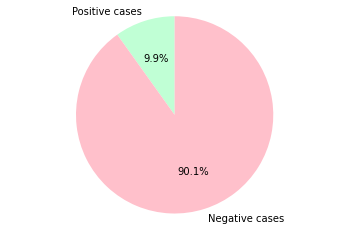

In [39]:
fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')

### Dealing with missing values

I am gonna del columns with missing data > 99% for +ve cases

['Fio2 (venous blood gas analysis)', 'D-Dimer', 'Urine - Nitrite', 'Partial thromboplastin time\xa0(PTT)\xa0', 'Prothrombin time (PT), Activity', 'Vitamin B12', 'Mycoplasma pneumoniae', 'Urine - Sugar', 'Albumin', 'Phosphor']


(-1.1275371457422187,
 1.111868446375018,
 -1.1088271473097018,
 1.100420340348081)

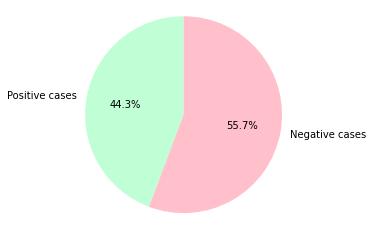

In [40]:
columns_to_exclude = missing_data_positive.index[missing_data_positive['Percent'] > 0.998].tolist()
data.drop(columns=columns_to_exclude, inplace=True)
print(columns_to_exclude)

# Redefine dataset positive and negative
dataset_negative = data[data['SARS-Cov-2 exam result'] == 0]
dataset_positive = data[data['SARS-Cov-2 exam result'] == 1]

dataset_negative = dataset_negative.dropna(axis=0, thresh=20)

X = pd.concat([dataset_negative, dataset_positive])

nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)

fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], 
        autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



Printing Correlation Vector again

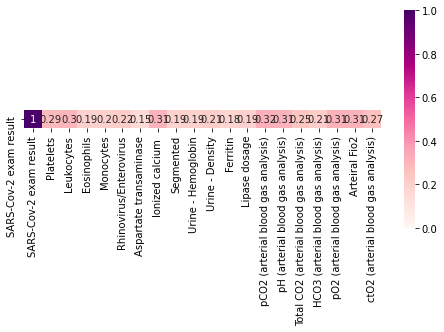

In [41]:
corrmat = abs(X.corr())

# Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15].index.tolist()

f, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(abs(X[relevant_features].corr().iloc[0:1, :]), yticklabels=[relevant_features[0]], xticklabels=relevant_features, vmin = 0.0, square=True, annot=True, vmax=1.0, cmap='RdPu')

## Training and Testing

Method 1 : Use only relevant features to train our model

In [42]:
relevant_features

['SARS-Cov-2 exam result',
 'Platelets',
 'Leukocytes',
 'Eosinophils',
 'Monocytes',
 'Rhinovirus/Enterovirus',
 'Aspartate transaminase',
 'Ionized calcium\xa0',
 'Segmented',
 'Urine - Hemoglobin',
 'Urine - Density',
 'Ferritin',
 'Lipase dosage',
 'pCO2 (arterial blood gas analysis)',
 'pH (arterial blood gas analysis)',
 'Total CO2 (arterial blood gas analysis)',
 'HCO3 (arterial blood gas analysis)',
 'pO2 (arterial blood gas analysis)',
 'Arteiral Fio2',
 'ctO2 (arterial blood gas analysis)']

In [43]:
X_with_relevant_features = X[relevant_features]
y_with_relevant_features = X_with_relevant_features['SARS-Cov-2 exam result']

In [44]:
X_with_relevant_features.drop(columns=['SARS-Cov-2 exam result'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Method 1 : Use All features to train our model

In [45]:
y = X['SARS-Cov-2 exam result']
X.drop(columns=['SARS-Cov-2 exam result'], inplace=True)

### Performance Metrics

In [46]:
def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%% " % (precision * 100))
    print("Recall: %.2f%% " % (recall * 100))
    print("AUC: %.2f%% " % (roc * 100))

def plot_confusion_matrix(y_test, y_pred):
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, cmap='RdPu')

### XGBoost

In [47]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.3, random_state=42)

X_test_xgb, X_validation_xgb, y_test_xgb, y_validation_xgb = train_test_split(X_test_xgb, y_test_xgb, test_size=0.5, random_state=42)

print("Number of samples in train set: %d" % y_train_xgb.shape)
print("Number of positive samples in train set: %d" % (y_train_xgb == 1).sum(axis=0))
print("Number of negative samples in train set: %d" % (y_train_xgb == 0).sum(axis=0))
print()
print("Number of samples in validation set: %d" % y_validation_xgb.shape)
print("Number of positive samples in validation set: %d" % (y_validation_xgb == 1).sum(axis=0))
print("Number of negative samples in validation set: %d" % (y_validation_xgb == 0).sum(axis=0))
print()
print("Number of samples in test set: %d" % y_test_xgb.shape)
print("Number of positive samples in test set: %d" % (y_test_xgb == 1).sum(axis=0))
print("Number of negative samples in test set: %d" % (y_test_xgb == 0).sum(axis=0))

model_xgb = XGBClassifier()

# Define parameters and grid search
n_estimators = [100, 300, 500, 700]
subsample = [0.5, 0.7, 1.0]
max_depth = [6, 7, 9]
grid = dict(n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
grid_search = GridSearchCV(estimator=model_xgb, param_grid=grid, n_jobs=-1, cv=10, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_xgb, y_train_xgb)
print("Best AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Number of samples in train set: 882
Number of positive samples in train set: 398
Number of negative samples in train set: 484

Number of samples in validation set: 189
Number of positive samples in validation set: 83
Number of negative samples in validation set: 106

Number of samples in test set: 189
Number of positive samples in test set: 77
Number of negative samples in test set: 112
Best AUC: 0.978362 using {'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}


Accuracy: 94.18%
Precision: 92.86% 
Recall: 93.98% 
AUC: 94.16% 
Accuracy: 94.71%
Precision: 95.89% 
Recall: 90.91% 
AUC: 94.12% 


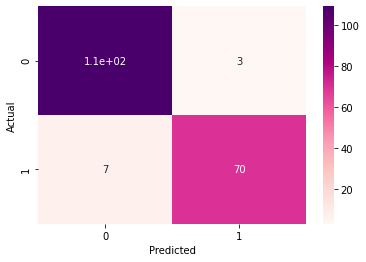

In [48]:
model_xgb.n_estimators = grid_result.best_params_['n_estimators']
model_xgb.subsample = grid_result.best_params_['subsample']
model_xgb.max_depth = grid_result.best_params_['max_depth']

model_xgb.fit(X_train_xgb, y_train_xgb, eval_metric='auc', eval_set=[(X_train_xgb, y_train_xgb), (X_validation_xgb, y_validation_xgb)], verbose=False)

val_predictions_xgb = model_xgb.predict(X_validation_xgb)
print_scores(y_validation_xgb, val_predictions_xgb)

predictions_xgb = model_xgb.predict(X_test_xgb)
print_scores(y_test_xgb, predictions_xgb)

plot_confusion_matrix(y_test_xgb, predictions_xgb)

FEATURE IMPORTANCE

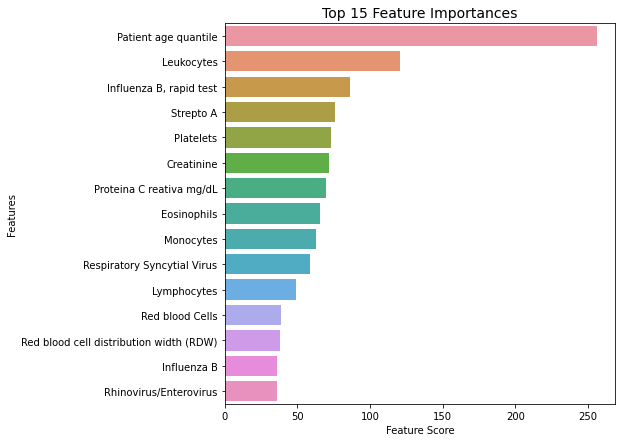

In [49]:
feature_importances = model_xgb.get_booster().get_fscore()
feature_importances_df = pd.DataFrame({'Feature Score': list(feature_importances.values()), 'Features': list(feature_importances.keys())})
feature_importances_df.sort_values(by='Feature Score', ascending=False, inplace=True)
feature_importances_df = feature_importances_df.head(15)

f, ax = plt.subplots(figsize=(7, 7))
plt.title('Top 15 Feature Importances', fontsize=14)
sns.barplot(x=feature_importances_df['Feature Score'], y=feature_importances_df['Features'])



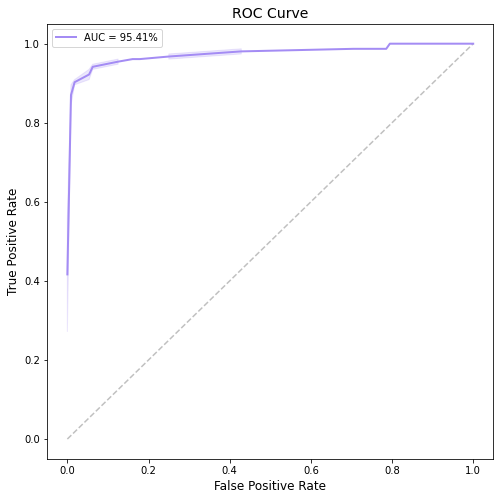

In [50]:
f, ax = plt.subplots(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='silver')
plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
fpr, tpr, thresholds = roc_curve(y_test_xgb, model_xgb.predict_proba(X_test_xgb)[:,1]) 
sns.lineplot(x=fpr, y=tpr, color=sns.color_palette("husl", 8)[-2], linewidth=2, label="AUC = 95.41%")

### Random Forest

In [51]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_with_relevant_features, y_with_relevant_features, test_size=0.2, random_state=42)

print("Number of samples in train set: %d" % y_train_rf.shape)
print("Number of positive samples in train set: %d" % (y_train_rf == 1).sum(axis=0))
print("Number of negative samples in train set: %d" % (y_train_rf == 0).sum(axis=0))
print()
print("Number of samples in test set: %d" % y_test_rf.shape)
print("Number of positive samples in test set: %d" % (y_test_rf == 1).sum(axis=0))
print("Number of negative samples in test set: %d" % (y_test_rf == 0).sum(axis=0))

imp = SimpleImputer(strategy='median')
imp = imp.fit(X_with_relevant_features)

rfc = RandomForestClassifier()

# Define parameters and grid search
n_estimators = [100, 300, 500, 800, 1000]
max_depth = [5, 8, 15, 25, 30]
grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search = GridSearchCV(estimator=rfc, param_grid=grid, n_jobs=-1, cv=10, scoring='recall', error_score=0)
grid_result = grid_search.fit(imp.transform(X_train_rf), y_train_rf)
print("Best recall: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Number of samples in train set: 1008
Number of positive samples in train set: 452
Number of negative samples in train set: 556

Number of samples in test set: 252
Number of positive samples in test set: 106
Number of negative samples in test set: 146
Best recall: 0.891546 using {'max_depth': 30, 'n_estimators': 500}


Accuracy: 82.14%
Precision: 72.59% 
Recall: 92.45% 
AUC: 83.56% 


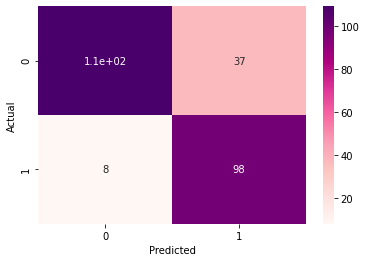

In [52]:
rfc.n_estimators = grid_result.best_params_['n_estimators']
rfc.max_depth = grid_result.best_params_['max_depth']
                                   
model_rfc = rfc.fit(imp.transform(X_train_rf), y_train_rf)

y_pred_rf = model_rfc.predict(imp.transform(X_test_rf))
print_scores(y_test_rf, y_pred_rf)

plot_confusion_matrix(y_test_rf, y_pred_rf)